In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [3]:
# 1. Baca data
df = pd.read_csv('data_siswa_seimbang.csv')

# Tangani missing values dengan interpolasi
df.interpolate(method='linear', inplace=True)

# 2. Cek kolom dan data awal
print(df.head())

   ID          Nama Jenis Kelamin  Usia  Nilai Matematika  Nilai IPA  \
0   1    Budi Putri             P    14                91         91   
1   2  Budi Saputra             L    13                86         92   
2   3   Gita Wijaya             L    15                86         86   
3   4       Eka Nur             L    14                92         92   
4   5   Budi Kusuma             P    12                91         85   

   Nilai IPS  Nilai Bahasa Indonesia  Nilai Bahasa Inggris  Nilai TIK  \
0         63                      67                    79         95   
1         69                      92                    77         88   
2         96                      88                    75         64   
3         73                      67                    96         97   
4         76                      70                    66         64   

   Minat Sains  Minat Bahasa  Minat Sosial  Minat Teknologi Potensi  
0            4             1             1                

<ipython-input-3-04303aab61a9>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [4]:
# 3. Encoding
label_encoder = LabelEncoder()
df['Potensi'] = label_encoder.fit_transform(df['Potensi'])
df['Jenis Kelamin'] = df['Jenis Kelamin'].map({'L': 0, 'P': 1})

# 4. Pisahkan fitur dan target
X = df.drop(['ID', 'Nama', 'Potensi'], axis=1)
y = df['Potensi']

In [5]:
# 5. Normalisasi dan one-hot encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_encoded = to_categorical(y)

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 7. Bangun model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 kelas

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
print(df['Potensi'].value_counts())

Potensi
1    125
0    125
2    125
3    125
Name: count, dtype: int64


In [7]:
# 8. Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# 9. Evaluasi
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

# 10. Simpan model dan label encoder jika ingin digunakan di web nanti
model.save("model_potensi.h5")
import joblib
joblib.dump(scaler, "scaler.save")
joblib.dump(label_encoder, "label_encoder.save")

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2621 - loss: 1.5584 - val_accuracy: 0.2875 - val_loss: 1.4200
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2393 - loss: 1.4245 - val_accuracy: 0.2875 - val_loss: 1.3179
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3735 - loss: 1.2919 - val_accuracy: 0.3750 - val_loss: 1.2384
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5222 - loss: 1.1729 - val_accuracy: 0.4875 - val_loss: 1.1587
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6390 - loss: 1.0890 - val_accuracy: 0.6125 - val_loss: 1.0807
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 1.0195 - val_accuracy: 0.6375 - val_loss: 0.9996
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6998 - loss: 0.9184 - val_accuracy: 0.7000 - val_loss: 0.9185
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7462 - loss: 0.8075 - val_accuracy: 0.7625 - 

Akurasi Model: 79.00%


['label_encoder.save']

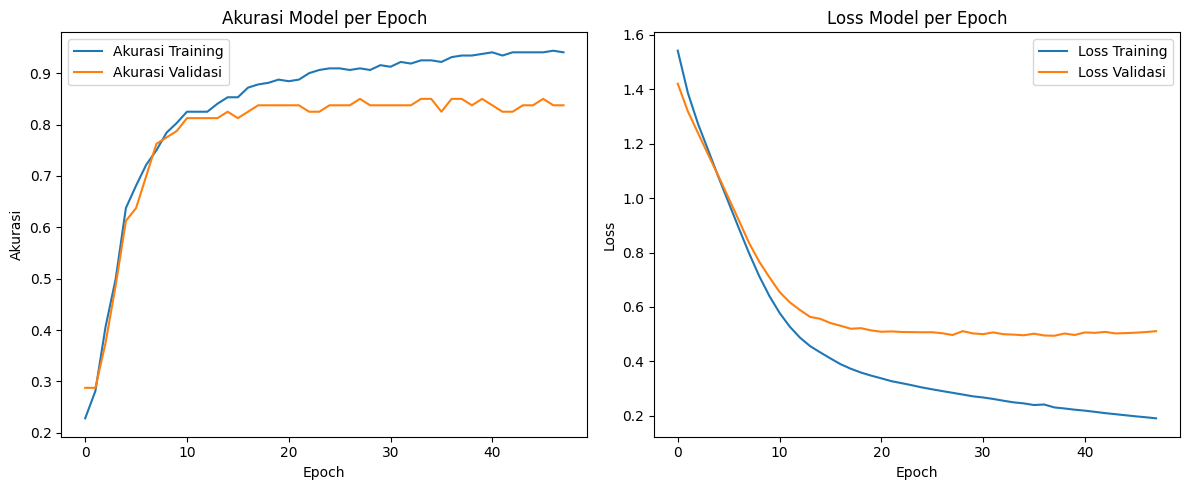

In [8]:
# Visualisasi akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Visualisasi loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Contoh data input dari siswa baru (dalam format sudah dinormalisasi)
X_sample = X_test[:5]  # Ambil 5 data dari test set

# Lakukan prediksi
y_pred = model.predict(X_sample)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test[:5], axis=1)

# Ubah label numerik ke nama kelas
predicted_potensi = label_encoder.inverse_transform(y_pred_labels)
actual_potensi = label_encoder.inverse_transform(y_true_labels)

# Tampilkan hasil
for i in range(5):
    print(f"Siswa {i+1}: Prediksi = {predicted_potensi[i]}, Asli = {actual_potensi[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Siswa 1: Prediksi = Bahasa, Asli = Sosial
Siswa 2: Prediksi = Bahasa, Asli = Sains
Siswa 3: Prediksi = Sosial, Asli = Sosial
Siswa 4: Prediksi = Teknologi, Asli = Bahasa
Siswa 5: Prediksi = Sains, Asli = Sains


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


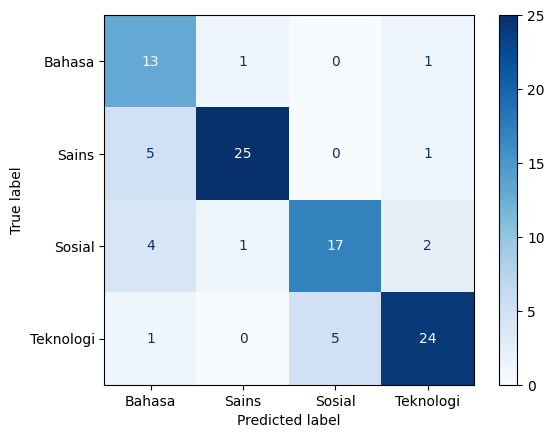

In [10]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_all = model.predict(X_test)
y_pred_labels_all = np.argmax(y_pred_all, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")

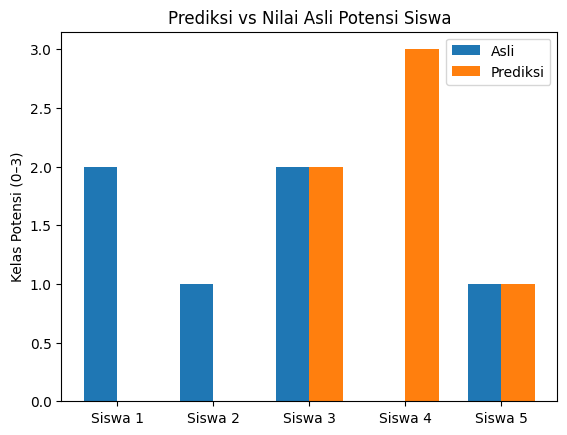

In [11]:
x = np.arange(5)
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, y_true_labels, width, label='Asli')
ax.bar(x + width/2, y_pred_labels, width, label='Prediksi')

ax.set_ylabel('Kelas Potensi (0–3)')
ax.set_title('Prediksi vs Nilai Asli Potensi Siswa')
ax.set_xticks(x)
ax.set_xticklabels([f"Siswa {i+1}" for i in range(5)])
ax.legend()

plt.show()